In this notebook, we present a numerical validation of the convergence order for both the EGA and Static-EGA results developed in the paper. We specifically focus on the results of the theorem 2.1 equation 17:
\begin{equation}
\begin{split}
\frac{\partial}{\partial\mathrm{\theta}}  {\Psi^n}(\mathrm{u}_{t})&=\sum_{j = 1}^{j = n-1} \prod_{i = 1}^{i = n-j} \underbrace{\frac{\partial \Psi(\Psi^{n-i}(\mathrm{u}_{t}))}{\partial \Psi^{n-i}(\mathrm{u}_{t})}}_{\text{Jacobian of the flow}} h \underbrace{\frac{\partial}{\partial\mathrm{\theta}} \mathrm{M}_{\mathrm{\theta}}(\Psi^{j -1}(\mathrm{u}_{t}))}_{\text{Gradient of the sub-model}}+ h\frac{\partial}{\partial\mathrm{\theta}} \mathrm{M}_{\mathrm{\theta}}(\Psi^{n-1}(\mathrm{u}_{t})) + {O(h^2)} 
\end{split}
\end{equation}
And the one of the corollary 2.1.2 equation 19 regarding the static EGA Approximation that we will be using in all our numerical experiments: 

\begin{equation}
\begin{aligned}
\frac{\partial}{\partial\mathrm{\theta}}  {\Psi^n}(\mathrm{u}_{t}) &= \sum_{j = 1}^{j = n} h \frac{\partial}{\partial\mathrm{\theta}} \mathrm{M}_{\mathrm{\theta}}(\Psi^{j -1}(\mathrm{u}_{t})) + O(h^2)
\end{aligned}
\end{equation} 

We do this by evaluating the error of the above gradient approximations when the time step ${h}$ varies from $10^{-1}$ to $10^{-4}$.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from generate_data import generate_data
from tqdm import tqdm
from functorch import make_functional
from utils import  extract_and_reset_grads

In [24]:
# NN correction
class ClosureTerm(torch.nn.Module):
    def __init__(self, params):
        super(ClosureTerm, self).__init__()
        # params of the neural correction to the dynamical model (FCN model)
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend(
            [torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
             range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])   
    
    def forward(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

Here, we define the hybrid model as a pytorch module, the gradient approximations are defined as follows: 
* In forward mode autodiff for the theorem 2.1 equation 17. This approximation assumes having access to the full jacobian of the flow and its implementation in reverse mode is not trivial. It is also easier to follow the gradient computation in forward mode. 
* In reverse mode autodiff by associating to the forward call a computational graph that correspond to some EGA approximation. For instance, EGA-Static will correspond to the result of the corollary 2.1.2 equation 19. EGA-ST is another 'straight through approximation' that uses the jacobian of the NN closure model as an approximation of the jacobian of the flow and EGA-J uses a first order jacobian approximation.

In [25]:
# "hybrid model"
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # dimensions :
        self.dim_state = params['dim_state']
        self.closure = ClosureTerm(params)
        # params of the true L63 system
        self.sigma = (torch.from_numpy(np.array(GD.parameters.sigma)).float())
        self.rho = (torch.from_numpy(np.array(GD.parameters.rho)).float())
        self.beta = (torch.from_numpy(np.array(GD.parameters.beta)).float())
    
    def dyn_net(self, t, inp):
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:,0] = self.sigma*(inp[:,1]-inp[:,0]);
        grad[:,1] = inp[:,0]*(self.rho-inp[:,2])-inp[:,1];
        grad[:,2] = inp[:,0]*inp[:,1] #+  self.beta*inp[:,2];
        return grad + self.closure(inp)

    def model_dt(self, inp, dt, t0=0,
                grad_mode='EGA-static'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt), method='dopri5')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt), method='dopri5')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred.data[-1, :, :]                
            return output_p
    def forward(self, dt, n, x0, grad_mode='EGA'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1], dt, grad_mode=grad_mode))
        pred_seq = torch.stack(pred)[:, :, :]
        return pred_seq

In [26]:
convergence_diag = {'time_steps': [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1], 'error_EGA_ST': [], 'error_EGA_Static': [], 'error_EGA_J': [], 'error_EGA_J_Euler': []}

In [27]:
# Generate Lorenz 63 simulations
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = convergence_diag['time_steps'][0]
    nb_loop_data = 60.0

# run the data generation
dataset = generate_data(GD)

In [29]:
for i in tqdm(range(len(convergence_diag['time_steps']))):
    params = {'dt_integration': convergence_diag['time_steps'][i], 'dim_state': 3, 'dim_output': 3, 'transition_layers': 2,
              'dim_hidden_dyn_mdl': 3, 'device': 'cpu',
              'seed': 0, 'n_steps': 20}
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    # make sure we use the same number of initial conditions per time resolution
    rat_data = int(convergence_diag['time_steps'][-1]/params['dt_integration'])
    subsampling = int(params['dt_integration']/convergence_diag['time_steps'][0])
    X_train = torch.from_numpy(dataset[::subsampling][::rat_data]).float()
    batch_size = X_train.shape[0]
    
    # hybrid model
    hybrid_model = HybridMdl(params)

    # EGA static
    pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], X_train, grad_mode='EGA-static')
    error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
    error1.backward()
    # params and gradients of EGA static
    grads_EGA_Static = extract_and_reset_grads(hybrid_model)

    # EGA Jacobian Euler
    pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], X_train, grad_mode='EGA-J')
    error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
    error1.backward()
    # params and gradients of EGA jacobian (assuming Euler jacobians)
    grads_EGA_J_Euler = extract_and_reset_grads(hybrid_model)

    # EGA straight through (keep the jacobian term of the NN model)
    pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], X_train, grad_mode='EGA-ST')
    error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
    error1.backward()
    
    # params and gradients of EGA straight through 
    grads_EGA_ST = extract_and_reset_grads(hybrid_model)

    # Exact gradient of the solver (autodiff of dopri8)
    pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], X_train, grad_mode='exact')
    error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
    error1.backward()
    
    # params and gradients of Exact gradient 
    grads_GT = extract_and_reset_grads(hybrid_model)
    
    # Compare backward mode autodiff to forward mode autodiff based on the analytical computation of the EGA (equation 17 in paper)
    with torch.no_grad():
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], X_train, grad_mode='exact')
    
    # compute gradient of the NN with respect to theta
    func, theta = make_functional(hybrid_model.closure)#torch.func.functional_call(hybrid_model.model_dt.closure)
    jac_theta_dict = torch.vmap(torch.func.jacrev(func), (None, 0))(theta, pred_mdl.detach())
    jac_theta_dict_flatten = [j.reshape(params['n_steps'] + 1, batch_size, params['dim_state'], -1)
                              for j in jac_theta_dict]
    jac_theta_dict_flatten = torch.cat(jac_theta_dict_flatten, dim=-1) * params['dt_integration']

    # compute exact jacobians using autodiff
    jacs = []
    for j in tqdm(range(params['n_steps'])):
        jacs.append(torch.autograd.functional.jacobian(lambda x: hybrid_model.model_dt(x,dt = params['dt_integration'], grad_mode = 'exact'), pred_mdl.detach()[j,:,:],vectorize=True)[np.arange(pred_mdl.shape[1]),:,np.arange(pred_mdl.shape[1]),:])
    jacs = torch.stack(jacs)
    
    # combine jacobians and gradient of NN to compute EGA (equation 14)
    grad_phi_n_all = []
    for kk in range(jac_theta_dict_flatten.shape[-1]):
        grad_phi_n = []
        for m in range(0, params['n_steps'], ):
            sum_cont = 0
            for k in range(m + 1):
                tmp = torch.eye(params['dim_state'])
                tmp = tmp.reshape((1, params['dim_state'], params['dim_state']))
                tmp = tmp.repeat(pred_mdl.shape[1], 1, 1)
                running_jac = [tmp]
                for i in range(m, k, -1):
                    running_jac.append(torch.bmm(running_jac[-1], jacs[i, :, :, :]))
                sum_cont += torch.bmm(running_jac[-1], jac_theta_dict_flatten[k, :, :, kk:kk + 1])
            grad_phi_n.append(sum_cont)
        grad_phi_n = torch.stack(grad_phi_n)
        grad_phi_n_all.append(grad_phi_n)
    
    # gradient of the cost function with respect to the last solver iteration
    coef = pred_mdl.reshape(-1).shape[0]
    grad0 = (2 * (pred_mdl - torch.zeros_like(pred_mdl))) / coef

    # gradient of the cost function with respect to the parameters
    grad_theta_n_all = []
    for kk in range(len(grad_phi_n_all)):
        grad_theta_n = []
        for i in range(params['n_steps'], ):
            grad_theta_n.append(torch.bmm(grad0.unsqueeze(2)[1 + i], grad_phi_n_all[kk][i]))
        grad_theta_n = torch.stack(grad_theta_n)
        grad_theta_n_all.append(grad_theta_n)
    grad_theta_n_all = torch.stack(grad_theta_n_all)
    grads_J = grad_theta_n_all.sum(dim=1).sum(dim=1).detach()[:, 0, 0]

    # compute gradient errors
    convergence_diag['error_EGA_ST'].append(grads_GT - grads_EGA_ST) 
    convergence_diag['error_EGA_Static'].append(grads_GT - grads_EGA_Static) 
    convergence_diag['error_EGA_J'].append(grads_GT - grads_J) 
    convergence_diag['error_EGA_J_Euler'].append(grads_GT - grads_EGA_J_Euler) 

  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7584\594524171.py:52: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func, theta = make_functional(hybrid_model.closure)#torch.func.functional_call(hybrid_model.model_dt.closure)

100%|██████████| 11/11 [22:19<00:00, 121.80s/it]


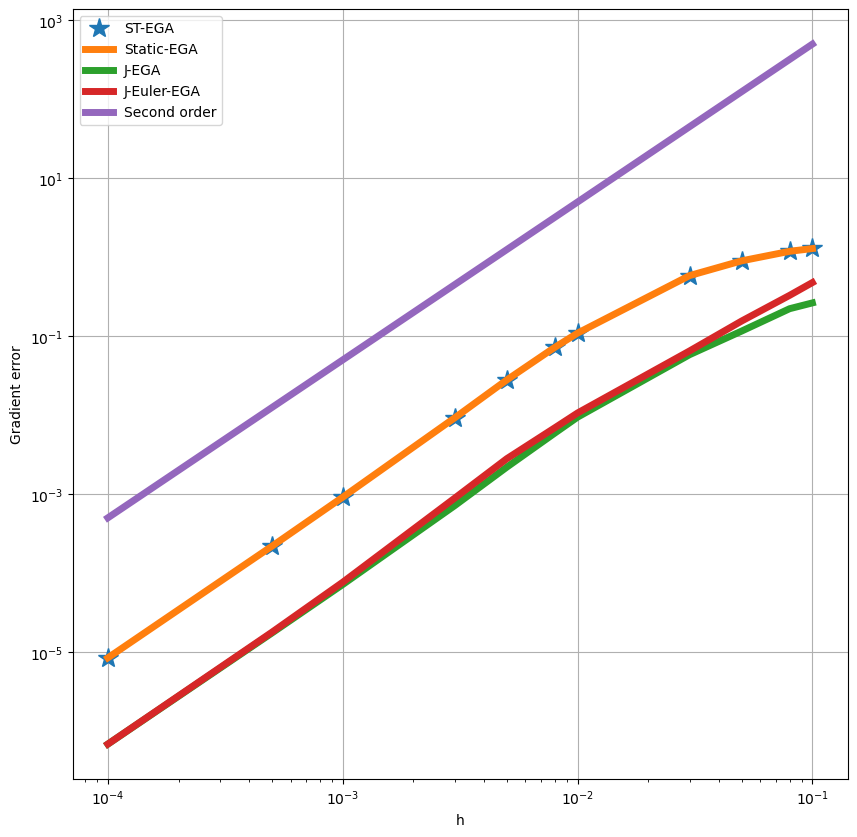

In [30]:
plt.figure(figsize=(10,10))
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_ST'])).mean(axis = -1),'*', markersize = 15, lw = 5, label = 'ST-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_Static'])).mean(axis = -1), lw = 5, label = 'Static-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_J'])).mean(axis = -1), lw = 5, label = 'J-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_J_Euler'])).mean(axis = -1), lw = 5, label = 'J-Euler-EGA')
plt.loglog(convergence_diag['time_steps'],50000*np.array(convergence_diag['time_steps'])**2, label = 'Second order', lw = 5)
plt.tick_params(axis='both')
plt.grid()
plt.legend()
plt.xlabel('h')
plt.ylabel('Gradient error')
plt.show()